In [3]:
import torch 
from torch import nn ,optim
from torch.nn import functional as F
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
#Normalizing the data and transforming to tensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
                                ])
#Downloading the train data and test data
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/",download =True,train=True,transform=transform)
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/",download=True,train=False,transform=transform)

#Loading the train data and test data
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64)
testloader = torch.utils.data.DataLoader(testset,batch_size=64)

In [5]:
#feed forward network
class Classifier(nn.Module):
  def __init__(self):
    super().__init__() # it track architecture by nn.Module class
    self.fc1 = nn.Linear(in_features=784,out_features=256)
    self.fc2 = nn.Linear(in_features=256,out_features=128)
    self.fc3 = nn.Linear(in_features=128,out_features=64)
    self.fc4 = nn.Linear(in_features=64,out_features=10)
  def forward(self,x):
    x = x.view(x.shape[0],-1) # flattening the input
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x),dim=1)
    return x

In [6]:
model = Classifier()
images, labels = next(iter(testloader))
print(images.shape,labels.shape)
ps = torch.exp(model(images))
print(ps.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 10])


In [7]:
top_p, top_class = ps.topk(k=1,dim=1)
print(top_class[:10]) # index position of highest value

tensor([[9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9]])


In [8]:
print(top_p[:10])# highest value

tensor([[0.1123],
        [0.1099],
        [0.1088],
        [0.1108],
        [0.1096],
        [0.1086],
        [0.1107],
        [0.1099],
        [0.1104],
        [0.1116]], grad_fn=<SliceBackward>)


In [9]:
print(ps[:10])

tensor([[0.0922, 0.0967, 0.1060, 0.0989, 0.0970, 0.1026, 0.0942, 0.1050, 0.0949,
         0.1123],
        [0.0933, 0.0931, 0.1058, 0.1004, 0.0958, 0.1055, 0.0937, 0.1052, 0.0972,
         0.1099],
        [0.0944, 0.0960, 0.1070, 0.0996, 0.0980, 0.1063, 0.0931, 0.1025, 0.0943,
         0.1088],
        [0.0960, 0.0953, 0.1056, 0.1008, 0.0977, 0.1034, 0.0917, 0.1049, 0.0938,
         0.1108],
        [0.0930, 0.0937, 0.1050, 0.0993, 0.0964, 0.1068, 0.0952, 0.1064, 0.0946,
         0.1096],
        [0.0939, 0.0947, 0.1041, 0.1007, 0.0983, 0.1056, 0.0940, 0.1058, 0.0943,
         0.1086],
        [0.0940, 0.0942, 0.1031, 0.1003, 0.0978, 0.1016, 0.0963, 0.1079, 0.0942,
         0.1107],
        [0.0939, 0.0959, 0.1031, 0.1008, 0.0965, 0.1050, 0.0936, 0.1066, 0.0949,
         0.1099],
        [0.0925, 0.0930, 0.1030, 0.1025, 0.0978, 0.1027, 0.0958, 0.1088, 0.0936,
         0.1104],
        [0.0931, 0.0962, 0.1045, 0.1011, 0.0968, 0.1033, 0.0943, 0.1053, 0.0938,
         0.1116]], grad_fn=<

In [10]:
print(top_class.shape,labels.shape) # so we need to convert the dimension 1d to 2d as top_class dimension for validating

torch.Size([64, 1]) torch.Size([64])


In [12]:
labels.view(*top_class.shape).shape

torch.Size([64, 1])

In [15]:
equals = top_class == labels.view(*top_class.shape)
equals[:10]

tensor([[ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

In [16]:
accuracy = torch.mean(equals)
accuracy # beacuse true or false are 0,1 as bytetensor so we need to convert in float 

RuntimeError: ignored

In [19]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
accuracy

tensor(0.0625)

In [20]:
accuracy.item()

0.0625

In [21]:
type(accuracy.item())

float

In [22]:
type(accuracy)

torch.Tensor

In [23]:
accuracy.item()*100

6.25

In [24]:
accuracy*100

tensor(6.2500)

In [25]:
model = Classifier()
creterion = nn.NLLLoss()
optimizer = optim.Adam(params=model.parameters(),lr=0.003)

In [27]:
epochs = 5
steps = 0
train_losses,test_losses = [],[]
for e in range(epochs):
  running_loss = 0
  for images,labels in trainloader:
    optimizer.zero_grad()
    log_ps = model(images)
    loss = creterion(log_ps,labels)
    loss.backward()
    optimizer.step()
    running_loss = running_loss + loss.item()
  else:
    test_loss = 0
    accuracy = 0
    # turning of gradients for validation, saves the memory and computation
    with torch.no_grad():
      for images,labels in testloader:
        log_ps = model(images)
        test_loss = test_loss + creterion(log_ps,labels)
        ps = torch.exp(log_ps)
        top_p,top_class = ps.topk(1,dim=1)
        equals = top_class==labels.view(*top_class.shape)
        accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))
  train_losses.append(running_loss/len(trainloader))
  test_losses.append(test_loss/len(testloader))
  print("Epoch {}/{}...".format(e+1,epochs),
        "Training Loss: {:.3f}...".format(running_loss/len(trainloader)),
        "Test Loss: {:.3f}...".format(test_loss/len(testloader)),
        "Test Accuracy: {:.3f}...".format(accuracy/len(testloader)))


Epoch 1/5... Training Loss: 0.517... Test Loss: 0.526... Test Accuracy: 0.803...
Epoch 2/5... Training Loss: 0.390... Test Loss: 0.412... Test Accuracy: 0.853...
Epoch 3/5... Training Loss: 0.352... Test Loss: 0.407... Test Accuracy: 0.852...
Epoch 4/5... Training Loss: 0.330... Test Loss: 0.390... Test Accuracy: 0.861...
Epoch 5/5... Training Loss: 0.313... Test Loss: 0.383... Test Accuracy: 0.860...


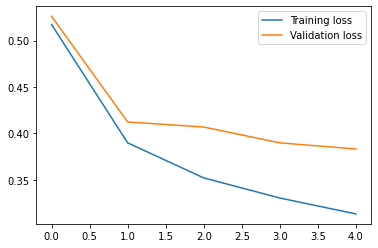

In [29]:
plt.plot(train_losses,label = "Training loss")
plt.plot(test_losses,label="Validation loss")
plt.legend()
plt.show()

Train and eval mode

In [30]:
#feed forward network
class Classifier(nn.Module):
  def __init__(self):
    super().__init__() # it track architecture by nn.Module class
    self.fc1 = nn.Linear(in_features=784,out_features=256)
    self.fc2 = nn.Linear(in_features=256,out_features=128)
    self.fc3 = nn.Linear(in_features=128,out_features=64)
    self.fc4 = nn.Linear(in_features=64,out_features=10)
    self.dropout = nn.Dropout(0.2)
  def forward(self,x):
    x = x.view(x.shape[0],-1) # flattening the input
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = F.log_softmax(self.fc4(x),dim=1) # output so no dropout here
    return x

In [31]:
epochs = 5
steps = 0
train_losses,test_losses = [],[]
for e in range(epochs):
  running_loss = 0
  for images,labels in trainloader:
    optimizer.zero_grad()
    log_ps = model(images)
    loss = creterion(log_ps,labels)
    loss.backward()
    optimizer.step()
    running_loss = running_loss + loss.item()
  else:
    test_loss = 0
    accuracy = 0
    # turning of gradients for validation, saves the memory and computation
    with torch.no_grad():
      model.eval() # it deactivate the dropout
      for images,labels in testloader:
        log_ps = model(images)
        test_loss = test_loss + creterion(log_ps,labels)
        ps = torch.exp(log_ps)
        top_p,top_class = ps.topk(1,dim=1)
        equals = top_class==labels.view(*top_class.shape)
        accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))
  model.train() # It will start training mode such dropout are activated
  train_losses.append(running_loss/len(trainloader))
  test_losses.append(test_loss/len(testloader))
  print("Epoch {}/{}...".format(e+1,epochs),
        "Training Loss: {:.3f}...".format(running_loss/len(trainloader)),
        "Test Loss: {:.3f}...".format(test_loss/len(testloader)),
        "Test Accuracy: {:.3f}...".format(accuracy/len(testloader)))


Epoch 1/5... Training Loss: 0.301... Test Loss: 0.414... Test Accuracy: 0.859...
Epoch 2/5... Training Loss: 0.289... Test Loss: 0.389... Test Accuracy: 0.864...
Epoch 3/5... Training Loss: 0.279... Test Loss: 0.384... Test Accuracy: 0.868...
Epoch 4/5... Training Loss: 0.275... Test Loss: 0.399... Test Accuracy: 0.867...
Epoch 5/5... Training Loss: 0.263... Test Loss: 0.399... Test Accuracy: 0.872...


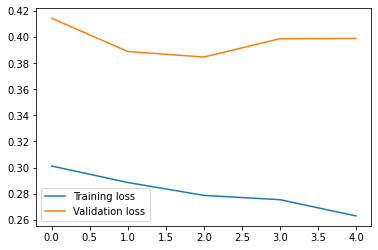

In [32]:
plt.plot(train_losses,label = "Training loss")
plt.plot(test_losses,label="Validation loss")
plt.legend()
plt.show()

Saving and Loading models

In [35]:
model

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [34]:
model.state_dict().keys()

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])

In [36]:
torch.save(model.state_dict(),"checkpoint.pth") #saving the model

In [37]:
ls

checkpoint.pth  sample_data/


In [38]:
state_dict = torch.load("checkpoint.pth") #Loading the state dict
state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])

In [39]:
model.load_state_dict(state_dict) #Loading the state dict into model

<All keys matched successfully>

In [40]:
model

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [41]:
epochs = 5
steps = 0
train_losses,test_losses = [],[]
for e in range(epochs):
  running_loss = 0
  for images,labels in trainloader:
    optimizer.zero_grad()
    log_ps = model(images)
    loss = creterion(log_ps,labels)
    loss.backward()
    optimizer.step()
    running_loss = running_loss + loss.item()
  else:
    test_loss = 0
    accuracy = 0
    # turning of gradients for validation, saves the memory and computation
    with torch.no_grad():
      model.eval() # it deactivate the dropout
      for images,labels in testloader:
        log_ps = model(images)
        test_loss = test_loss + creterion(log_ps,labels)
        ps = torch.exp(log_ps)
        top_p,top_class = ps.topk(1,dim=1)
        equals = top_class==labels.view(*top_class.shape)
        accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))
  model.train() # It will start training mode such dropout are activated
  train_losses.append(running_loss/len(trainloader))
  test_losses.append(test_loss/len(testloader))
  print("Epoch {}/{}...".format(e+1,epochs),
        "Training Loss: {:.3f}...".format(running_loss/len(trainloader)),
        "Test Loss: {:.3f}...".format(test_loss/len(testloader)),
        "Test Accuracy: {:.3f}...".format(accuracy/len(testloader)))


Epoch 1/5... Training Loss: 0.254... Test Loss: 0.395... Test Accuracy: 0.875...
Epoch 2/5... Training Loss: 0.251... Test Loss: 0.408... Test Accuracy: 0.873...
Epoch 3/5... Training Loss: 0.244... Test Loss: 0.404... Test Accuracy: 0.870...
Epoch 4/5... Training Loss: 0.238... Test Loss: 0.426... Test Accuracy: 0.873...
Epoch 5/5... Training Loss: 0.230... Test Loss: 0.429... Test Accuracy: 0.873...


In [54]:
class Network(nn.Module):
  def __init__(self,input_size,output_size,hidden_layers,drop_p=0.5):
    """Builds a feedforward network with arbitary hiddenlayer
       Arguments
       ---------
       input_size: defining
       output_size: defination
       hidden_layer: defination
    """
    super().__init__()
    self.hidden_layers = nn.ModuleList([nn.Linear(input_size,hidden_layers[0])])
    print(self.hidden_layers)
    layer_sizes = zip(hidden_layers[:-1],hidden_layers[1:])
    print(hidden_layers[:-1],hidden_layers[1:])
    self.hidden_layers.extend([nn.Linear(h1,h2) for h1,h2 in layer_sizes])
    self.output  = nn.Linear(hidden_layers[-1],output_size)
    self.dropout = nn.Dropout(p=drop_p)
  def forward(self,x):
    for each in self.hidden_layers:
      x = F.relu(each(x))
      x = self.dropout(x)
    x = self.output(x)
    return F.log_softmax(x,dim =1)

model = Network(784,10,[512,256,128,10])
model

ModuleList(
  (0): Linear(in_features=784, out_features=512, bias=True)
)
[512, 256, 128] [256, 128, 10]


Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (output): Linear(in_features=10, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [50]:
layer_sizes = zip([512, 256, 128],[256, 128, 10])
for h1,h2 in layer_sizes:
  print(h1,h2)

512 256
256 128
128 10


In [58]:
epochs = 5
steps = 0
train_losses,test_losses = [],[]
for e in range(epochs):
  running_loss = 0
  for images,labels in trainloader:
    images.resize_(images.size()[0],784)
    optimizer.zero_grad()
    log_ps = model(images)
    loss = creterion(log_ps,labels)
    loss.backward()
    optimizer.step()
    running_loss = running_loss + loss.item()
  else:
    test_loss = 0
    accuracy = 0
    # turning of gradients for validation, saves the memory and computation
    with torch.no_grad():
      model.eval() # it deactivate the dropout
      for images,labels in testloader:
        images.resize_(images.size()[0],784)
        log_ps = model(images)
        test_loss = test_loss + creterion(log_ps,labels)
        ps = torch.exp(log_ps)
        top_p,top_class = ps.topk(1,dim=1)
        equals = top_class==labels.view(*top_class.shape)
        accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))
  model.train() # It will start training mode such dropout are activated
  train_losses.append(running_loss/len(trainloader))
  test_losses.append(test_loss/len(testloader))
  print("Epoch {}/{}...".format(e+1,epochs),
        "Training Loss: {:.3f}...".format(running_loss/len(trainloader)),
        "Test Loss: {:.3f}...".format(test_loss/len(testloader)),
        "Test Accuracy: {:.3f}...".format(accuracy/len(testloader)))


Epoch 1/5... Training Loss: 2.321... Test Loss: 2.319... Test Accuracy: 0.096...
Epoch 2/5... Training Loss: 2.321... Test Loss: 2.319... Test Accuracy: 0.096...
Epoch 3/5... Training Loss: 2.321... Test Loss: 2.319... Test Accuracy: 0.096...
Epoch 4/5... Training Loss: 2.321... Test Loss: 2.319... Test Accuracy: 0.096...
Epoch 5/5... Training Loss: 2.320... Test Loss: 2.319... Test Accuracy: 0.096...


In [59]:
torch.save(model.state_dict(),"abc.pth")
state_dict = torch.load("abc.pth")
model.load_state_dict(state_dict)
model

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (output): Linear(in_features=10, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [105]:
#!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip